# Building a Variable Star classifier

This notebook will take you through the basic steps to build a classification tool using scikit-learn. It relies on the dataset provided and a small library of functions built for this workshop. You must start the notebook from inside the Dataset directory. If you feel comfortable with Python you can try having a look at the specific functions and making changes, although that's best left until after the class.

In [2]:
import numpy as np
%matplotlib notebook
import pylab as plt
import os

## Workshop 1: Understand the data

In [3]:
#Load the plotting function from workshop1.py
from workshop1 import plotLC

Unstanding what your data looks like is critical. Try changing the dataset and exploring the different kinds of variable star.
The options are 'RRLYR_CEPHEID','SOLARLIKE','ECLIPSE','GDOR_SPB','DSCT_BCEP','CONTACT_ROT','CONSTANT','APERIODIC'

What characteristics does each class have? Are there key distinguishing features we could use to separate them? Identifying these yourself can save the computer a lot of processing time. This is known as 'expert' or 'domain' knowledge.

In [5]:
#load the dataset for one type of variable star. Default is Eclipsing binaries but try some others
dat = np.genfromtxt('APERIODIC.txt') #or any of the class text files
len(dat[2])

1341

In [6]:
len(dat)

830

<IPython.core.display.Javascript object>


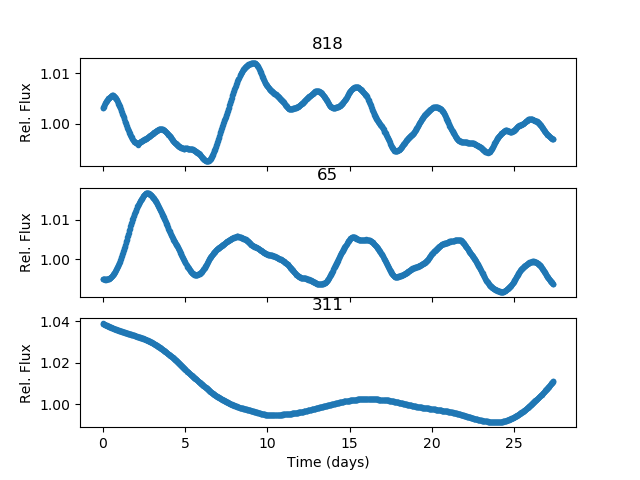

In [7]:
#run this cell repeatedly - you'll get a random selection of stars in the dataset each time 
#Remember to rerun the above cell if you want to change the class
plotLC(dat)  #repeat
#press the power symbol at the top right of the figure when you're finished

## Workshop 2: Making a feature set

What data do we actually pass to a machine learning algorithm? Direct lightcurve data can be a very inefficient strategy, and often has issues with gaps among other things.

This workshop constructs a set of features from the lightcurve data. It also builds a useful set of auxiliary features. The latter part is largely hidden to allow this to fit in a single short workshop, but you can adapt the detailed functions in workshop2.py if you like.

In [24]:
#import some library functions from workshop2.py
from workshop2 import bin_lightcurves, make_featureset, plotbinLC
classes = ['RRLYR_CEPHEID','SOLARLIKE','ECLIPSE','GDOR_SPB','DSCT_BCEP','CONTACT_ROT','CONSTANT','APERIODIC']

The below cell does most of the work. It will take a while to run - typically 30 seconds on my laptop.

Try changing the options for phasefold, scale, offset, and number of bins in the 'bin_lightcurves' function. See what this does to the plots later on. Which options are likely to work best for classifying lightcurves? Good choices save you time later. Always try to take work away from the computer, if you can do it simply and without biasing the results.

In [25]:
'''   
These functions save the resulting data in text files - this is not really needed here, 
but for actual use-cases you want to minimise the whole dataset sitting in the computer's memory, and back
up each processing stage.

Don't change the filepaths or later cells might break.
'''

datdict, freqdict, binlcdict, ampdict = {}, {}, {}, {}

for kind in classes:
    #iterate over the classes. Some auxiliary data is loaded in, mainly the strongest frequencies in each lightcurve
    
    #make binned lightcurves so they are aligned across different stars
    #Using scale=True and offset=True will produce nonsensical results if phasefold is not True.
    datdict[kind], freqdict[kind], binlcdict[kind], ampdict[kind] = bin_lightcurves(kind+'.txt', frequencyfile=kind+'_freq.txt', outfile=kind+'_bin.txt', 
                                                                                    phasefold=True, scale=True, offset=True, bins=64)
    #make auxiliary feature set
    make_featureset(datdict[kind], freqdict[kind], ampdict[kind], kind+'_features.txt')
    


<IPython.core.display.Javascript object>


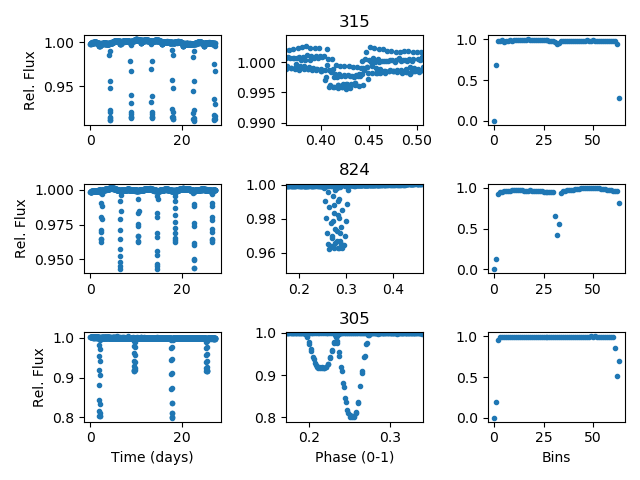

In [59]:
#Make sure to press the power symbol in the above figure before running this cell.

#repeat this cell to get different random stars
kind = 'ECLIPSE' #or any of the classes
plotbinLC(datdict[kind],freqdict[kind],binlcdict[kind]) 

#hit the power symbol when you're done

## Workshop 3: Classification

Here we're going to actually build the classifier, using whatever choices you made in Workshop 2.

In [27]:
#import the library functions
from workshop3 import merge_datasets, plot_distributions, make_confusion_matrix

There are several steps. First we merge the datasets made above into one set. You can choose to use just the lightcurve data (after binning etc), just the auxiliary features, or both. Try different options.

In [49]:
#combine the feature sets produced into one dataset we can use for classification
X, y = merge_datasets(features=True, binnedlcs=True) #at least one of these has to be True

TypeError: 'tuple' object is not callable

Now we can look at some of the features and see if they have distinguishing power by themselves. This can be a good way of understanding what you've done when building a feature set.

If you included features when running merge_datasets, col = 0 represents the strongest frequency in the lightcurve, col=6 represents the skewness. If you like, try the others, you can look up what they are in 'make_featureset' in workshop2.py.

<IPython.core.display.Javascript object>


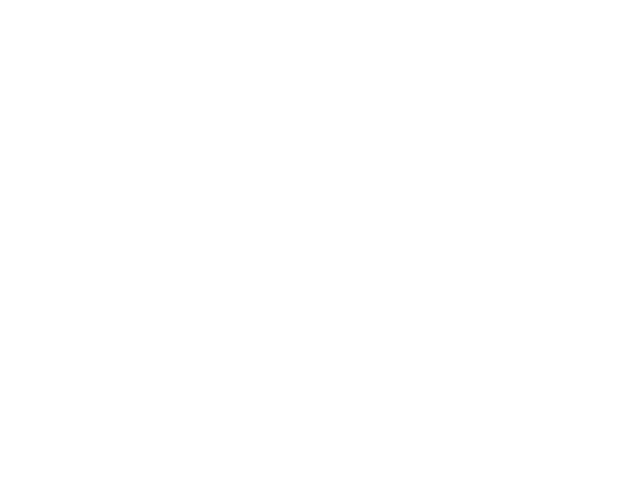

In [48]:
plot_distributions(X, y, bins=80, col=8)
#as always, hit the power symbol when you're done.
#hold your cursor over an axes and press k or l to toggle log axes on and off

Now we split the dataset into training and test sets. This is crucial for accurately measuring model performance. Never test a model on the same examples it was trained on.

In [30]:
from sklearn.model_selection import train_test_split
#stratify is VERY important with imbalanced training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,shuffle=True)
# n.b. stratify line is super important if test set are unbalanced (just makes sure there is the same proportion of each type)

At last, the actual classification! I've set up two models here, K-nearest neighbours and Random Forest. You can choose either and try changing some of the inputs. Follow the links to see the documentation on each model and descriptions of the inputs.

Some more examples are highlighted in workshop3.py if you want to explore.

In [31]:
#choose one and comment out the other

##

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
#from sklearn.neighbors import KNeighborsClassifier
#try changing n_neighbours and weights. 
#weights can be 'uniform' or 'distance' (follow link above to learn the difference)
#n_neighbours - larger tends to blur out noise but makes classification boundaries less distinct
#knn = KNeighborsClassifier(n_neighbors=10,weights='uniform')
#knn.fit(X_train, y_train)
#y_probabilities = knn.predict_proba(X_test)
#y_predict = knn.predict(X_test)

### OR ###

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
#try removing the 'balanced' class weights and see what happens
rfc = RandomForestClassifier(max_depth=5, n_estimators=1000, max_features='auto',class_weight='balanced')
rfc.fit(X_train, y_train)
y_probabilities = rfc.predict_proba(X_test)
y_predict = rfc.predict(X_test)

##

You might have found that cell surprisingly quick to run. Part of that is the default inputs, but part is that relatively simple ML algorithms like these are not very expensive. Multi-layered neural nets etc increase the processing time dramatically, and aren't always needed.

Scikit-learn is excellent for trying out different models - they all take the same format as input. It's not the best for complex nets or other 'deep learning' techniques, but is a good place to start to try and understand your problem before getting into tensorflow or other options.

Now we test our models.

Log-loss:  0.7548176915718092
AUC:  0.9840965828116927
Accuracy:  0.8824553765781454
Precision:  0.8869151142726016
Recall:  0.8824553765781454


<IPython.core.display.Javascript object>


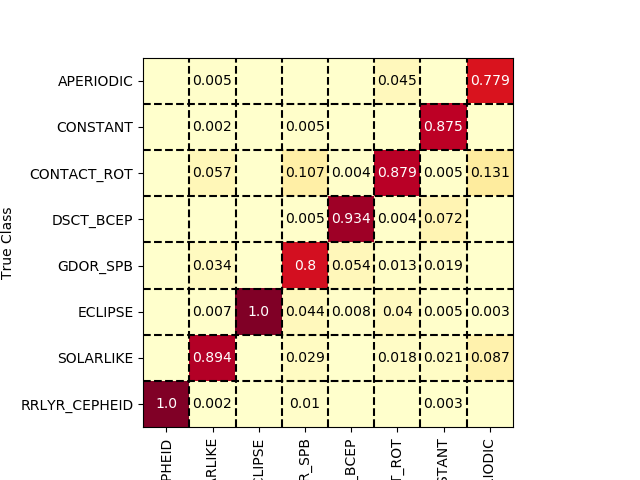

In [33]:
#print various metrics
import sklearn.metrics as metrics
print('Log-loss: ',metrics.log_loss(y_test,y_probabilities))
print('AUC: ',metrics.roc_auc_score(y_test,y_probabilities,average='weighted',multi_class='ovr'))
print('Accuracy: ',metrics.accuracy_score(y_test,y_predict))
print('Precision: ',metrics.precision_score(y_test,y_predict,average='weighted'))
print('Recall: ',metrics.recall_score(y_test,y_predict,average='weighted'))

#plot the confusion matrix. This is a very useful plot for understanding multi-class classification results
make_confusion_matrix(y_test,y_predict)


Success! At least if you like eclipsing binaries (using the defaults).

Models tend to either fail dramatically, or mostly work. That's reason to be careful, sometimes models don't do what you expect, but look ok on the surface. Always have a look at the outputs, and examples of failed classifications.

In [39]:
print(len(y_predict))


2297


In [56]:
X.shape[1]

72

In [57]:
X[0,0]

1.72009327